In [38]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc3 as pm
import corner

from glob import glob
from numpy.random import normal
from scipy.stats import sigmaclip
from scipy.stats import lognorm
from scipy.special import hyp1f1
from scipy.special import gamma
from scipy.interpolate import interp1d
from astropy.coordinates import Distance
from frb.dm.igm import average_DM
from frb.dm import igm
from frb.dm import cosmic
from frb.dm import mcmc
from frb import defs
from astropy.cosmology import Planck18 as cosmo
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from astropy.table import Table
from pkg_resources import resource_filename

from observable import do_mcmc
from observable import get_file_zs, get_file_galaxies, observed_bands, draw_Delta

sns.set_theme(style='whitegrid')

ModuleNotFoundError: No module named 'ipympl'

In [2]:
textwidth = 7.0282  # might also be from latex textwidth=17.85162cm columnwidth=8.5744cm
columnwidth = 3.37574803  #3.3

small_size = 8
medium_size = 10
bigger_size = 12

sns.set_theme(style="ticks", context="talk")

# plt.rc('font', size=small_size)          # controls default text sizes
# plt.rc('axes', titlesize=small_size)     # fontsize of the axes title
# plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
# plt.rc('legend', fontsize=small_size)    # legend fontsize
# plt.rc('figure', titlesize=bigger_size)  # fontsize of the figure title


In [3]:
palette = sns.color_palette('Set2')

In [4]:
# Load FRBs from the pickle files.
n_frbs = 1000
#pickles = sorted(glob('Simulated_FRBs/Old parameter runs/*.pickle'))
pickles = sorted(glob('Simulated_FRBs/*.pickle'))
survey_models, z_models = [], []
for file in pickles:
    # Extract models from file names.
    params = os.path.basename(file)
    params = os.path.splitext(params)[0]
    params = params.split('_', 1)
    survey_models.append(params[0])
    z_models.append(params[1])

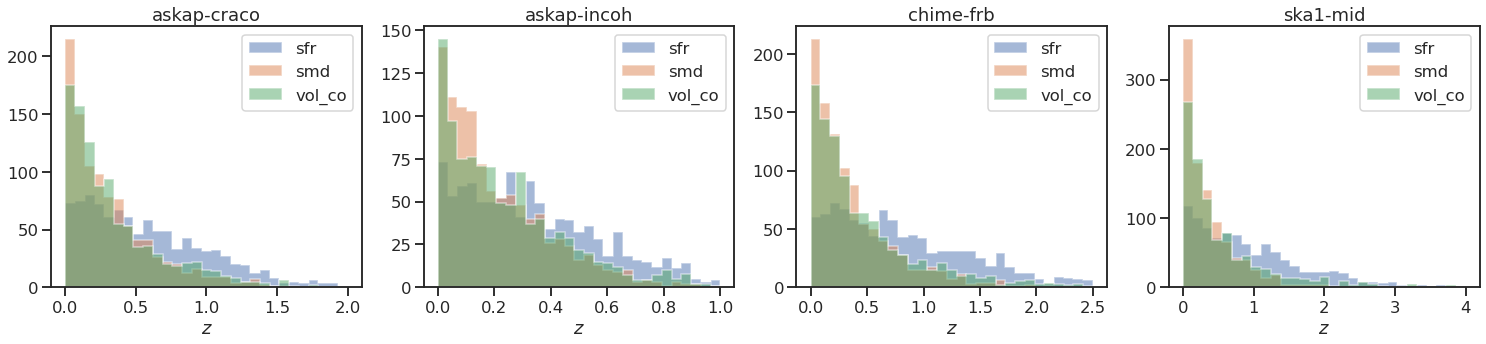

In [7]:
n_models = len(pickles)//3
fig, axs = plt.subplots(1, n_models, figsize=(n_models*6.4, 4.8))
z_max = [2, 1, 2.5, 4.]

for i, file in enumerate(pickles):
    frbs = np.load(file, allow_pickle=True)
    frbs = frbs.iloc[:n_frbs]
    ax = axs[i // 3]
    bins = np.linspace(0, z_max[i // 3], 30)
    ax.hist(frbs['z'], label=z_models[i], density=False, bins=bins, histtype='stepfilled', alpha=.5)
    #sns.histplot(frbs['z'], label=z_models[i], bins=bins, ax=ax) #, histtype='stepfilled', alpha=.5, density=False
    ax.set_title(survey_models[i])
    ax.set_xlabel(r"$z$")
    ax.legend()

In [8]:
pickles

['Simulated_FRBs/askap-craco_sfr.pickle',
 'Simulated_FRBs/askap-craco_smd.pickle',
 'Simulated_FRBs/askap-craco_vol_co.pickle',
 'Simulated_FRBs/askap-incoh_sfr.pickle',
 'Simulated_FRBs/askap-incoh_smd.pickle',
 'Simulated_FRBs/askap-incoh_vol_co.pickle',
 'Simulated_FRBs/chime-frb_sfr.pickle',
 'Simulated_FRBs/chime-frb_smd.pickle',
 'Simulated_FRBs/chime-frb_vol_co.pickle',
 'Simulated_FRBs/ska1-mid_sfr.pickle',
 'Simulated_FRBs/ska1-mid_smd.pickle',
 'Simulated_FRBs/ska1-mid_vol_co.pickle']

In [9]:
# Find files with galaxies from GALFORM files and get the redshifts.
gal_files = glob('Galform_galaxies/**/frb.cat', recursive=True)
snap_zs = np.array([get_file_zs(gal_file) for gal_file in gal_files])

# Sort by redshift.
z_order = snap_zs.argsort()
snap_zs = snap_zs[z_order]
if np.any(snap_zs[:-1] == snap_zs[1:]):
    raise ValueError("There are duplicats in the snapshots, it's likely iz105 which is weird.")
gal_files = [gal_files[i] for i in z_order]

In [10]:
gal_files, snap_zs

(['Galform_galaxies/frb.II/iz271/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz226/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz207/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz190/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz176/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz155/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz142/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz130/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz120/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz112/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz105/ivol0/frb.cat',
  'Galform_galaxies/frb.II/iz82/ivol0/frb.cat'],
 array([0.   , 0.249, 0.496, 0.757, 1.007, 1.496, 2.002, 2.51 , 3.046,
        3.534, 4.008, 6.011]))

In [9]:
# # Create a latex table of snapshots.
# for i, file in enumerate(gal_files):
#     galaxy_pop = get_file_galaxies(file)
#     print(f"{i} & {snap_zs[i]} & {galaxy_pop.shape[0]} \\\\")

In [12]:
# Pick an FRB survey and redshift distribution
chosen = pickles[0]
radio_survey = survey_models[0]
print(chosen)

# Weight galaxy choice depending on file name
if os.path.splitext(chosen)[0][-3:] == 'sfr':  # last thre letters before extension
    weights = 'mstardot'
else:
    weights = 'mstars_total'

# Make bins around the catalog snapshots
bins = np.concatenate((snap_zs[0:1], snap_zs[:-1] + np.diff(snap_zs)/2, snap_zs[-1:] + 50.))

rng = np.random.default_rng(seed=42)  #42

#n_z_bins = 29   # Three lines and 3 lines at bottom are to test variation between different runs
#n_observed_sdss = np.zeros([10, n_z_bins], dtype=int)
#for i in range(10):
frbs = np.load(chosen, allow_pickle=True)
print(frbs.shape[0], "FRBs in file, using only first", n_frbs)
frbs = frbs.iloc[:n_frbs].copy()

nums_to_draw = np.histogram(frbs['z'], bins=bins)[0]
relev_snap = nums_to_draw != 0
snaps = relev_snap.nonzero()[0]

Simulated_FRBs/askap-craco_sfr.pickle
1028 FRBs in file, using only first 1000


In [16]:
# Draw galaxies from the GALFORM files. This assumes they are sorted like their redshifts.
galaxies = []
for snap, n_draw in zip(snaps, nums_to_draw[relev_snap]):
    galaxy_pop = get_file_galaxies(gal_files[snap])
    galaxy_pop.loc[:, 'redshift'] = snap_zs[snap]
    galaxy_pop.loc[:, 'snapnum'] = snap
    galaxies.append(galaxy_pop.sample(n=n_draw, replace=False, weights=weights, random_state=rng))

galaxies = pd.concat(galaxies)

# Order FRBs such that they correspond to galaxies at the same positions.
frbs.loc[:, 'snapnum'] = np.digitize(frbs['z'].to_numpy(), bins) - 1
frbs.sort_values('snapnum', ascending=True, inplace=True)

n_bands_obs_SDSS, n_bands_obs_LSST, n_bands_obs_Euclid, n_bands_obs_DES, fluxish = observed_bands(frbs, galaxies)

frbs['fluxish'] = fluxish.to_numpy()

frbs['n_bands_SDSS'] = n_bands_obs_SDSS.to_numpy()
frbs['n_bands_LSST'] = n_bands_obs_LSST.to_numpy()
frbs['n_bands_Euclid'] = n_bands_obs_Euclid.to_numpy()
frbs['n_bands_DES'] = n_bands_obs_DES.to_numpy()

In [17]:
# plt.close('all')
# fig, ax = plt.subplots()
# means = n_observed_sdss.mean(0)
# stds = n_observed_sdss.std(0)
# plt.step(np.linspace(0, z_max[0], n_z_bins+1)[:], [0]+list(means))
# plt.step(np.linspace(0, z_max[0], n_z_bins+1)[:], [0]+list(means + 2*stds))
# plt.step(np.linspace(0, z_max[0], n_z_bins+1)[:], [0]+list(means - 2*stds))
# ax.set_xlabel('z')
# ax.set_ylabel('Galaxies visible in all bands')

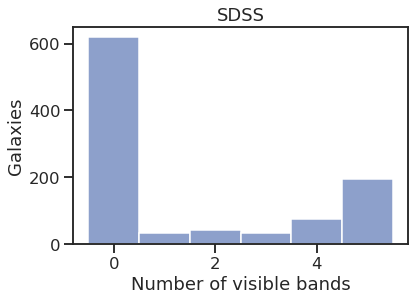

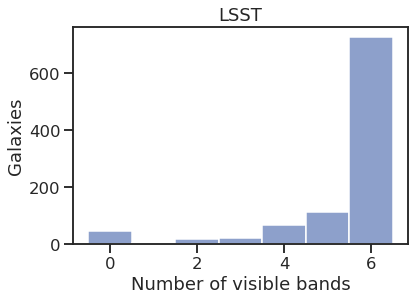

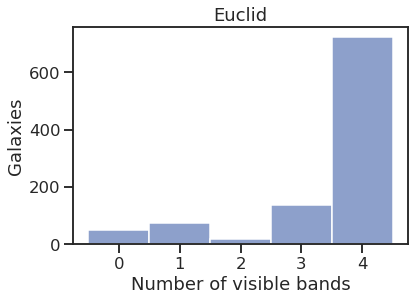

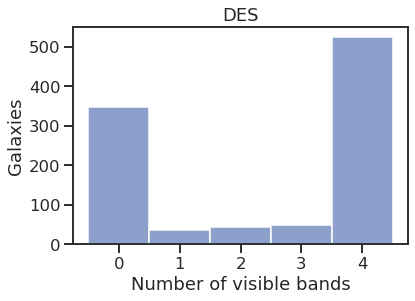

In [18]:
plt.close('all')
#fig, axs = plt.subplots(1, 3, figsize=(3*6.4, 4.8))
for i, survey in enumerate(['SDSS', 'LSST', 'Euclid', 'DES']):
    fig, ax = plt.subplots()
    axs = [ax]
    i = 0
    n_bands_obs = frbs['n_bands_' + survey]
    n_bands = n_bands_obs.max()
    axs[i].hist(n_bands_obs, bins=np.linspace(-.5, n_bands+.5, n_bands+2), color=palette[2])
    axs[i].set_xlabel('Number of visible bands')
    axs[i].set_ylabel('Galaxies')
    axs[i].set_title(survey)
    #fig.savefig(f"n_bands_{radio_survey}_{survey}.png", dpi=300, bbox_inches='tight')
    

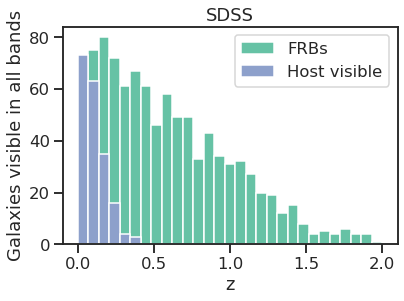

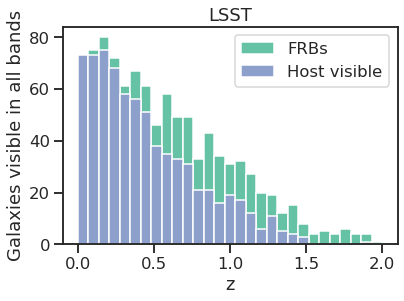

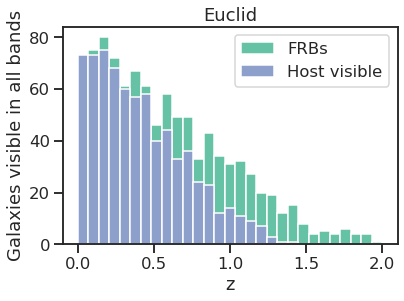

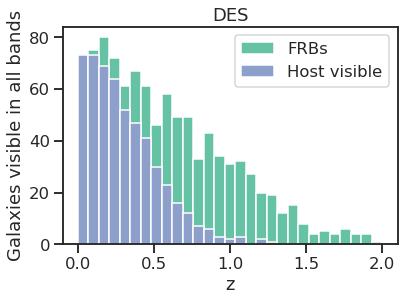

In [19]:
plt.close('all')
#fig, axs = plt.subplots(1, 3, figsize=(3*6.4, 4.8))
for i, survey in enumerate(['SDSS', 'LSST', 'Euclid', 'DES']):
    fig, ax = plt.subplots()
    axs = [ax]
    i = 0
    n_bands_obs = frbs['n_bands_' + survey]
    n_bands = n_bands_obs.max()
    axs[i].hist(frbs['z'], density=False, bins=np.linspace(0, z_max[0], 30), color=palette[0], label="FRBs")  #bins[bins<2], alpha=0.5
    axs[i].hist(frbs.loc[n_bands_obs.to_numpy() == n_bands, 'z'], density=False, alpha=1, bins=np.linspace(0, z_max[0], 30), color=palette[2], label="Host visible")  #, color='orange'
    axs[i].set_xlabel('z')
    axs[i].set_ylabel('Galaxies visible in all bands')
    axs[i].set_title(survey)
    axs[i].legend()
    
    #fig.savefig(f"visible_galaxies_{radio_survey}_{survey}.png", dpi=300, bbox_inches='tight')

#plt.hist(frbs['z'], density=False, alpha=0.5, bins=np.linspace(0, z_max[0], 30), color='blue')  #bins[bins<2]
#plt.hist(frbs.loc[n_bands_obs.to_numpy() > 0, 'z'], density=False, alpha=0.5, bins=np.linspace(0, z_max[0], 30), color='orange')  #bins[bins<2]
#plt.hist(galaxies['Redshift']+1e-4, density=True, alpha=0.5, bins=bins[:30], color='orange')
#plt.hist(galaxies[n_bands_obs > 0]['Redshift']+1e-4, density=False, alpha=0.5, bins=bins[:30], color='orange')

In [20]:
# Coverage
# Chime: https://arxiv.org/pdf/2106.04353.pdf or Figure 4 in https://arxiv.org/pdf/2106.04352.pdf 
# SDSS: http://classic.sdss.org/dr7/coverage/index.html
# LSST: https://www.lsst.org/scientists/survey-design and the book there chapter 3
# Euclid: https://sci.esa.int/web/euclid/-/59042-euclid-mission-sky-coverage   Fig.2 in https://arxiv.org/pdf/1610.05508.pdf
# ASKAP: -90° < δ < ~+49° https://research.csiro.au/racs/home/survey/ 


# Redshift error

# Euclid: spectroscopic: σ(z)<0.001(1+z), from Red book: https://sci.esa.int/documents/33220/36137/1567255801368-EUCLID_RB_Issue_1-1_2011-09-29HighQ.pdf
# Photometric: Parameter Requirement            Goal 
# Redshifts error        (σ(z)/(1+z)) < 0.05     < 0.03
# Catastrophic failures 10%                      5% 
# 
# Assumed in https://arxiv.org/pdf/1606.00180.pdf  ∆z= 0.05*(1+z)

# LSST redshiftrange 0.3–3.0 with an accuracy of 1-2%, 3σ (“catastrophic”) outliers must be below 10%, bias must be below 0.003  https://www.lsst.org/scientists/publications/science-requirements-document
# 

In [21]:
# Give parameter values from which to simulate the DM. Obh70 is not used at the moment, would have to give it to averag_DM.
Obh70, F, mu, lognorm_s = cosmo.Ob0*cosmo.H0.value/70, .2, 100, 1

# Calculate the average DM up to the highest redshift, interpolate to avoid using this slow function again.
# (For every neval an integral is done in frb.dm.igm.avg_rhoISM when cosmo.age(z) is called.)
DM_cum, zeval = average_DM(frbs['z'].max(), cosmo=defs.frb_cosmo, cumul=True)
avrg_DM = interp1d(zeval, DM_cum, assume_sorted=True)

# Draw a DM_IGM from it's PDF. Multiply by <DM_cosmic> to get a DM.
rng = np.random.default_rng(seed=42)
delta = [float(draw_Delta(z, f=F, n_samples=1, rng=rng)) for z in frbs['z']]
dm_cosmic = np.array(delta) * avrg_DM(frbs['z'])

# Draw a DM_host from the parameters that Macquart2020 gives.
dm_host = lognorm.rvs(lognorm_s, scale=mu, size=len(frbs['z']), random_state=rng)

frbs['DM'] = dm_host/(1+frbs['z']) + dm_cosmic

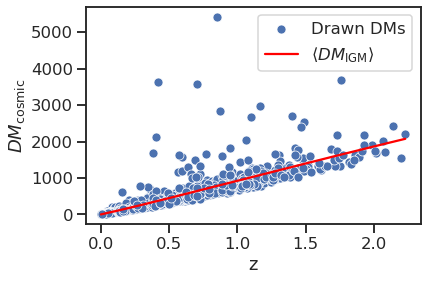

In [22]:
# Plot distributions to see their worth.
plt.close('all')
fig, ax = plt.subplots()
# Plot the data.
sns.scatterplot(x=frbs['z'], y=dm_cosmic, ax=ax, label="Drawn DMs")
ax.set_xlabel("z")
ax.set_ylabel(r"$DM_\mathrm{cosmic}$")

z = np.linspace(0, frbs['z'].max(), 1000)
sns.lineplot(x=z, y=avrg_DM(z), ax=ax, color='red', label=r"$\langle DM_\mathrm{IGM}\rangle$")

ax.legend()

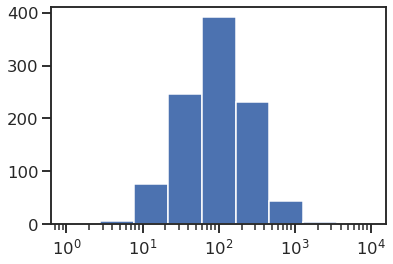

In [23]:
fig, ax = plt.subplots()
#dm_host2 =  np.random.lognormal(mean=np.log(100), sigma=1.0, size=1000)
ax.hist(dm_host, bins=np.logspace(0, 4, 10))
#ax.hist(dm_host2, bins=np.logspace(0, 4, 10), color='red')
plt.xscale('log')

In [24]:
def log_likelihood_variable_step(Obh70, F, in_DM_FRBp, z_FRB, mu=100., 
                                 lognorm_floor=0, lognorm_s=1., beta=3., 
                                 res=500):
    """Calculate the log likelihood for a set of FRBs.
    
    Compared to the previously used "all_prob", this function includes a
    factor of <DM_cosmic> that comes from changeing the integration to Delta,
    i.e. from dDM = dDelta * <DM_cosmic>. On top, this function has a
    significant speed up due to a variable stepsize and the use of
    broadcasting.

    Args:
        Obh70 (float): Value of Omega_b * h_70
        F (float): Feedback parameter
        in_DM_FRBp (np.ndarray): Measured DMs with DM_MW already subtracted.
        z_FRB (np.ndarray): FRB redshifts.
        mu (float, optional):
            Mean of log-normal PDF of DM_host (in DM units).
        lognorm_s (float, optional):
            Sigma of log-normal PDF of DM_host (in log space).
        beta (float, optional):
            Parameter for DM PDF.
        res (int, optional):
            Number of steps to use for the integral over the DM.
            In a test with 200 FRBs the difference between res=100 and
            res=10000 was only 0.3%.

    Returns:
        float:  Log likelihood
    """
    # Sigma for each FRB.
    sigma = F / np.sqrt(z_FRB)
    # C0 for each FRB.
    if beta == 4.:
        raise ValueError("Bad beta value in all_prob")
        C0 = tt_spl_C0(sigma)
    elif beta == 3.:
        #C0 = tt_spl_C0_3(sigma)
        C0 = f_C0_3(sigma)
    else:
        raise IOError

    # Get the average DM for each z from the globally created spline.
    avgDM = spl_DMc(z_FRB) * (Obh70 / cosmo_Obh70)

    # Integrate over P_host and P_cosmic in eq. 7 of Macquart et al. 2020 using the rectangle rule.
    steps = in_DM_FRBp/(res+1)  # Integration steps
    DM_values = np.linspace(steps/2, in_DM_FRBp-steps/2, res, axis=-1)  # 0th axis are the FRBs.

    Delta = (in_DM_FRBp[:, np.newaxis] - DM_values) / avgDM[:, np.newaxis]
    PDF_Cosmic = cosmic.DMcosmic_PDF(Delta, C0[:, np.newaxis], sigma[:, np.newaxis], beta=beta)
    PDF_host = lognorm.pdf(DM_values*(1+z_FRB[:, np.newaxis]), s=lognorm_s, scale=mu)
    likelihoods = steps*np.sum(PDF_Cosmic * PDF_host, axis=-1)

    if beta == 3.:
        # Calculate the normalization "analytically" to be fast.
        hyp_x = -C0**2/18/sigma**2
        normalizations = 3*(12*sigma)**(1/3)/(gamma(1/3)*3*sigma*hyp1f1(1/6, 1/2, hyp_x)
                                             + 2**(1/2)*C0*gamma(5/6)*hyp1f1(2/3, 3/2, hyp_x))
    else:
        # Integrate numerically. This is slower by a factor 146 (with 20000 samples).
        step = 20/20000
        Delta = np.linspace(step, 20.-step, 20000)
        normalizations = cosmic.DMcosmic_PDF(Delta, C0[:, np.newaxis], sigma[:, np.newaxis], beta=beta)
        normalizations = 1 / (step * normalizations.sum(axis=-1))
        
    # Normalization matters because it is different for each FRB. The factor avgDM comes because
    # normalizations is the integral over Delta instead of DM. avgDM was missing in previous
    # versions.
    log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
    return log_like

In [25]:
f_C0_3 = cosmic.grab_C0_spline()

#DM_cosmic, zeval = igm.average_DM(3, cosmo=cosmo, cumul=True)
spl_DMc = IUS(zeval, DM_cum.value)

cosmo_Obh70 = cosmo.Ob0 * (cosmo.H0.value/70.)

mcmc.all_prob = log_likelihood_variable_step

survey = 'DES'
n_bands_obs = frbs['n_bands_' + survey]
n_bands = n_bands_obs.max()

# Limit to FRBs with host in all bands and shuffle them.
frbs_w_host = frbs[n_bands_obs.to_numpy() == n_bands]  #[(n_bands_obs.to_numpy() == n_bands) & (frbs['z'] < 1)]  #
rng = np.random.default_rng(seed=42)
frbs_w_host = frbs_w_host.sample(frac=1, ignore_index=True, random_state=rng)

mcmc.spl_DMc = spl_DMc  # Probbly not needed when function is defined here

In [26]:
len(frbs)

1000

In [27]:
draws = 1500
cores = 20

frb_set = frbs_w_host

n_frbs = len(frb_set)
print(n_frbs)

524


In [28]:
outdir = 'Posteriors'
post_path = os.path.join(outdir, f"{radio_survey}_{survey}_{n_frbs}_zs_{cores}x{draws}_draws.nc")
if not os.path.isfile(post_path):
    mcmc.frb_zs = frb_set['z'].to_numpy()
    mcmc.frb_DMs = frb_set['DM'].to_numpy()

    parm_dict = mcmc.grab_parmdict()
    with mcmc.pm_four_parameter_model(parm_dict, beta=3.):
        # Sample
        #trace = pm.sample(40000, tune=2000) # This defaults to 4 chains
        idata = pm.sample(draws, tune=300, cores=cores, return_inferencedata=True, discard_tuned_samples=True, progressbar=False,)

        idata.to_netcdf(post_path)

else:
    print("Already existing, skip.")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (20 chains in 20 jobs)
CompoundStep
>Slice: [lognorm_s]
>Slice: [mu]
>Slice: [F]
>Slice: [Obh70]
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoo

In [29]:
# Creat random samples from the FRB population to compare with.
rndm_sample1 = frbs.sample(n=n_frbs, ignore_index=True, random_state=rng)
rndm_sample2 = frbs.sample(n=n_frbs, ignore_index=True, random_state=rng)
rndm_sample3 = frbs.sample(n=n_frbs, ignore_index=True, random_state=rng)

for frb_set in [rndm_sample1, rndm_sample2, rndm_sample3]:
    outdir = 'Posteriors'
    i = 0
    post_path = os.path.join(outdir, f"{radio_survey}_{survey}_random_sample_of_{len(frb_set)}_zs_run_{i}_{cores}x{draws}_draws.nc")
    while os.path.isfile(post_path):
        i += 1
        post_path = os.path.join(outdir, f"{radio_survey}_{survey}_random_sample_of_{len(frb_set)}_zs_run_{i}_{cores}x{draws}_draws.nc")
        
    print(f"Will save to {post_path}")

    mcmc.frb_zs = frb_set['z'].to_numpy()
    mcmc.frb_DMs = frb_set['DM'].to_numpy()

    parm_dict = mcmc.grab_parmdict()
    with mcmc.pm_four_parameter_model(parm_dict, beta=3.):
        # Sample
        idata = pm.sample(draws, tune=300, cores=cores, return_inferencedata=True, discard_tuned_samples=True, progressbar=False,)

        idata.to_netcdf(post_path)

Will save to Posteriors/askap-craco_random_sample_of_524_zs_run_0_20x1500_draws.nc


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (20 chains in 20 jobs)
CompoundStep
>Slice: [lognorm_s]
>Slice: [mu]
>Slice: [F]
>Slice: [Obh70]
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoo

Will save to Posteriors/askap-craco_random_sample_of_524_zs_run_1_20x1500_draws.nc


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (20 chains in 20 jobs)
CompoundStep
>Slice: [lognorm_s]
>Slice: [mu]
>Slice: [F]
>Slice: [Obh70]
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoo

Will save to Posteriors/askap-craco_random_sample_of_524_zs_run_2_20x1500_draws.nc


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (20 chains in 20 jobs)
CompoundStep
>Slice: [lognorm_s]
>Slice: [mu]
>Slice: [F]
>Slice: [Obh70]
Sampling 20 chains for 300 tune and 1_500 draw iterations (6_000 + 30_000 draws total) took 3743 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [34]:
sorted(list(set(np.logspace(1, np.log10(len(frbs_w_host)), 30, dtype=int))))

[10,
 11,
 13,
 15,
 17,
 19,
 22,
 26,
 29,
 34,
 39,
 44,
 51,
 58,
 67,
 77,
 88,
 101,
 116,
 133,
 153,
 175,
 201,
 230,
 264,
 303,
 347,
 398,
 457,
 523]

In [37]:
draws = 1500
cores = 20

for n_frbs in [5,7]: #sorted(list(set(np.logspace(1, np.log10(len(frbs_w_host)), 30, dtype=int)))):  #[1000, 500, 300, 750, 400]: #range(10, len(frbs_w_host)+10, 10):  
    print(n_frbs)

    outdir = 'Posteriors'
    post_path = os.path.join(outdir, f"{radio_survey}_{survey}_{n_frbs}_zs_{cores}x{draws}_draws.nc")
    if os.path.isfile(post_path):
        continue
    
    frb_set = frbs_w_host.iloc[:n_frbs]

    mcmc.frb_zs = frb_set['z'].to_numpy()
    mcmc.frb_DMs = frb_set['DM'].to_numpy()

    parm_dict = mcmc.grab_parmdict()
    with mcmc.pm_four_parameter_model(parm_dict, beta=3.):
        # Sample
        #trace = pm.sample(40000, tune=2000) # This defaults to 4 chains
        idata = pm.sample(draws, tune=300, cores=cores, return_inferencedata=True, discard_tuned_samples=True, progressbar=False,)

        idata.to_netcdf(post_path)


5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (20 chains in 20 jobs)
CompoundStep
>Slice: [lognorm_s]
>Slice: [mu]
>Slice: [F]
>Slice: [Obh70]
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoo

7


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (20 chains in 20 jobs)
CompoundStep
>Slice: [lognorm_s]
>Slice: [mu]
>Slice: [F]
>Slice: [Obh70]
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoods*normalizations/avgDM))
/tmp/ipykernel_121866/1552272071.py:70: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(likelihoo

(0.0, 100.0)

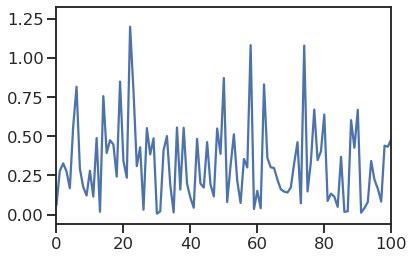

In [41]:
plt.plot(frbs_w_host.index, frbs_w_host['z'])
plt.xlim(0,100)